### BigData & Blockchain Lab
#### BTC-USD Price Prediction as regression problem with Deep LSTM NN.


#### Presented by @SAnbaee

In [1]:
import tensorflow as tf
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization
from matplotlib import pyplot as plt
import ta
from matplotlib import pyplot as plt

In [2]:

SEQ_LEN = 7 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 400  # how many passes through our data
BATCH_SIZE = 64



In [3]:
def IndicatorsAddition(df):
  
    df = ta.utils.dropna(df)
    # Initialize Bollinger Bands Indicator
    indicator_bb = ta.volatility.BollingerBands(close=df["Close"], n=20, ndev=2)
    '''
    set 1 :
    Stochastic %K, Stochastic %D, Momentum, Rate of change,
    William’s %R, Accumulation/Distribution (A/D)
    
    set 2
    EMA, MACD, RSI, On Balance Volume, Bollinger Bands
    
    '''
    df['stochastic'] = ta.momentum.StochasticOscillator(high = df['High'], low = df['Low'],
                                                        close = df['Close'], n = 14, d_n = 3,
                                                        fillna = False).stoch()
    
    df['momentum'] = ta.momentum.AwesomeOscillatorIndicator(high = df['High'], low = df['Low'], 
                                                            s = 5, len = 34, fillna= False) .ao()
    
    df['wiliams'] = ta.momentum.WilliamsRIndicator(high = df['High'], low = df['Low'], 
                                                   close = df['Close'], lbp = 14, fillna = False).wr()
    
    df ['ADI'] = ta.volume.AccDistIndexIndicator(high = df['High'], low = df['Low'], close = df['Close']
                                                 , volume = df['Volume'], fillna = False).acc_dist_index()
    
    
    df['EMA'] = ta.trend.EMAIndicator(close = df['Close'], n = 14, fillna = False).ema_indicator()
    
    
    df['MACD'] = ta.trend.MACD(close = df['Close'], n_slow = 26, n_fast = 12,
                               n_sign = 9, fillna = False).macd()
    
    df['RSI'] = ta.momentum.RSIIndicator(close = df['Close'], n = 14, fillna = False).rsi()
    
    df['on_balance_volume'] = ta.volume.OnBalanceVolumeIndicator(close = df['Close'], volume = df['Volume'],
                                                                 fillna = False).on_balance_volume()
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    
    return df
    


In [4]:
def normalization(df):
    #df = df.drop("future", 1)  # don't need this anymore.
    df = df.drop("High", 1)  # don't need this anymore.
    df = df.drop("Low", 1)  # don't need this anymore.
    df = df.drop("Open", 1)  # don't need this anymore.
    df = df.drop("Volume", 1)  # don't need this anymore.

    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df = df.replace([np.inf, -np.inf], None)
            df.dropna(inplace=True )  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    return df


In [5]:
def preprocess_df(df):
    
    df  = normalization(df)
    date = df.index.values[SEQ_LEN-1:]
    sequential_data = []  # this is a list that will CONTAIN the sequences
    
    # These will be our actual sequences. 
    #they are made with deque, which keeps
    #the maximum length by popping out older 
    #values as new ones come in
    prev_days = deque(maxlen=SEQ_LEN)  

    for i in df.values:  # iterate over the values
    
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 10 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # i[-1] is the sequence target
            

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    
    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return list(date) , np.array(X), y  # return X and y...and make X a numpy array!


In [6]:
import requests
from datetime import datetime 
import pandas as pd

startDate = datetime(2019,10,1).timestamp()
startDate = int(startDate)
print(startDate)
endDate = datetime.now().timestamp()
endDate = int(endDate)

print(endDate)
queryString = 'https://finnhub.io/api/v1/crypto/candle?symbol=BINANCE:BTCUSDT&resolution=D&from='
queryString += str(startDate ) + '&to=' + str(endDate)+ '&token='

columns={'Close','High','Low','Open','Status','timestamp','Volume'}
r = requests.get(queryString)

df = pd.DataFrame(r.json())

df['Close'] = df['c']
df = df.drop('c',1)

df['Open'] = df['o']
df = df.drop('o',1)

df['Low'] = df['l']
df = df.drop('l',1)

df['High'] = df['h']
df = df.drop('h',1)

df = df.drop('s',1)


df['timestamp'] = df['t']
df = df.drop('t',1)

df['Volume'] = df['v']
df = df.drop('v',1)

df['Date'] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in df['timestamp']]
df = df.drop('timestamp',1)



1569875400
1604488858


In [7]:

print(df.head())
print(df.describe())
print(df.Date[:1])
print(df.Date[-1:])

     Close     Open      Low     High        Volume        Date
0  8292.44  8289.97  8173.05  8500.00  43472.418091  2019-10-01
1  8359.94  8292.67  8151.22  8373.91  26243.386644  2019-10-02
2  8223.96  8360.00  8060.00  8393.00  30488.284058  2019-10-03
3  8137.13  8224.43  8005.00  8232.41  26476.330404  2019-10-04
4  8126.19  8137.09  8012.98  8183.41  21907.615564  2019-10-05
              Close          Open           Low          High         Volume
count    401.000000    401.000000    401.000000    401.000000     401.000000
mean    9163.346010   9149.853716   8934.550549   9351.887731   62345.643899
std     1740.833904   1726.678793   1732.144551   1725.267180   38512.203841
min     4800.000000   4800.010000   3782.130000   5365.420000   16792.388165
25%     7929.870000   7929.870000   7672.000000   8124.920000   39137.946167
50%     9192.560000   9179.010000   9037.470000   9307.850000   53865.069929
75%    10223.080000  10219.290000   9880.750000  10397.600000   72337.595259


In [8]:
main_df = df
main_df['timestamp'] = main_df['Date'] #+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('Date' ,1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)

# add indicators 
main_df = IndicatorsAddition(main_df) 


# add target 
main_df['target'] = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
#target = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
#target = np.array(target)
#target = target.reshape(-1,1)
#scale target between 0 to 1
#min_max_scaler = preprocessing.MinMaxScaler()
#main_df['scaled target']= min_max_scaler.fit_transform(target)

 


In [9]:
#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 20% of the times

test_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%




dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.25*len(dates))]  # get the last 20% of the times
validation_main_df =  main_df[(main_df.index > last_5pct)]  
main_df = main_df[(main_df.index < last_5pct)] 

print(main_df.shape)
print(validation_main_df.shape)
print(test_main_df.shape)

print(main_df.head())
print(main_df.describe())


(241, 15)
(79, 15)
(80, 15)
              Close     Open      Low     High        Volume  stochastic  \
timestamp                                                                  
2019-10-01  8292.44  8289.97  8173.05  8500.00  43472.418091         NaN   
2019-10-02  8359.94  8292.67  8151.22  8373.91  26243.386644         NaN   
2019-10-03  8223.96  8360.00  8060.00  8393.00  30488.284058         NaN   
2019-10-04  8137.13  8224.43  8005.00  8232.41  26476.330404         NaN   
2019-10-05  8126.19  8137.09  8012.98  8183.41  21907.615564         NaN   

            momentum  wiliams           ADI  EMA  MACD  RSI  \
timestamp                                                     
2019-10-01       NaN      NaN -11723.392271  NaN   NaN  NaN   
2019-10-02       NaN      NaN  11227.344398  NaN   NaN  NaN   
2019-10-03       NaN      NaN  10762.237843  NaN   NaN  NaN   
2019-10-04       NaN      NaN  15052.518725  NaN   NaN  NaN   
2019-10-05       NaN      NaN  22249.651832  NaN   NaN  NaN  

In [ ]:
d1 , data_x, data_y = preprocess_df(main_df)

In [13]:
print(test_main_df)
d1 , train_x, train_y = preprocess_df(main_df)
d2 , validation_x, validation_y = preprocess_df(validation_main_df)
d3 , test_x, test_y = preprocess_df(test_main_df)

print(train_x.shape)
print(f"train data: {len(train_x)} ")
print(f"validation data: {len(validation_x)}")
print(f"test Data: {len(test_x)}")




               Close      Open       Low      High        Volume  stochastic  \
timestamp                                                                      
2020-08-17  12281.13  11910.99  11769.78  12468.00  84734.211540   87.270436   
2020-08-18  11945.01  12281.15  11817.93  12387.77  75923.835527   61.964364   
2020-08-19  11754.59  11945.10  11561.00  12020.08  73940.169606   46.879375   
2020-08-20  11853.55  11754.38  11668.00  11888.00  46085.254351   54.247952   
2020-08-21  11531.34  11853.54  11485.81  11878.00  64448.306142   30.256143   
...              ...       ...       ...       ...           ...         ...   
2020-10-31  13791.00  13560.10  13411.50  14100.00  67339.238515   88.779060   
2020-11-01  13761.50  13791.00  13603.00  13895.00  36285.648526   87.425893   
2020-11-02  13549.37  13761.49  13195.05  13830.00  64566.421908   77.269331   
2020-11-03  14023.53  13549.63  13284.99  14066.11  74115.630787   96.544588   
2020-11-04  13675.01  14023.53  13525.00

In [11]:
EPOCHS = 500  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.


In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1))



In [15]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=opt,
   
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            71168     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [16]:
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
     validation_data=(validation_x, np.array(validation_y)),
    )


Train on 193 samples, validate on 63 samples
Epoch 1/400
193/193 [==============================] - 9s 46ms/sample - loss: 99.9852 - val_loss: 99.9980
Epoch 2/400
193/193 [==============================] - 0s 989us/sample - loss: 99.9610 - val_loss: 99.9958
Epoch 3/400
193/193 [==============================] - 0s 849us/sample - loss: 99.9420 - val_loss: 99.9929
Epoch 4/400
193/193 [==============================] - 0s 1ms/sample - loss: 99.9292 - val_loss: 99.9891
Epoch 5/400
193/193 [==============================] - 0s 932us/sample - loss: 99.9116 - val_loss: 99.9841
Epoch 6/400
193/193 [==============================] - 0s 854us/sample - loss: 99.8909 - val_loss: 99.9778
Epoch 7/400
193/193 [==============================] - 0s 808us/sample - loss: 99.8766 - val_loss: 99.9696
Epoch 8/400
193/193 [==============================] - 0s 860us/sample - loss: 99.8566 - val_loss: 99.9588
Epoch 9/400
193/193 [==============================] - 0s 875us/sample - loss: 99.8413 - val_loss: 99.

193/193 [==============================] - 0s 839us/sample - loss: 95.6069 - val_loss: 96.2358
Epoch 70/400
193/193 [==============================] - 0s 777us/sample - loss: 95.4436 - val_loss: 96.2228
Epoch 71/400
193/193 [==============================] - 0s 829us/sample - loss: 95.2231 - val_loss: 96.2016
Epoch 72/400
193/193 [==============================] - 0s 829us/sample - loss: 95.0568 - val_loss: 96.1092
Epoch 73/400
193/193 [==============================] - 0s 1ms/sample - loss: 94.9196 - val_loss: 95.8771
Epoch 74/400
193/193 [==============================] - 0s 891us/sample - loss: 94.6543 - val_loss: 95.6552
Epoch 75/400
193/193 [==============================] - 0s 844us/sample - loss: 94.6200 - val_loss: 95.3827
Epoch 76/400
193/193 [==============================] - 0s 829us/sample - loss: 94.3206 - val_loss: 95.0976
Epoch 77/400
193/193 [==============================] - 0s 823us/sample - loss: 94.0571 - val_loss: 94.7788
Epoch 78/400
193/193 [=====================

193/193 [==============================] - 0s 937us/sample - loss: 67.5768 - val_loss: 56.7668
Epoch 145/400
193/193 [==============================] - 0s 797us/sample - loss: 67.3002 - val_loss: 56.1471
Epoch 146/400
193/193 [==============================] - 0s 813us/sample - loss: 66.2817 - val_loss: 54.4677
Epoch 147/400
193/193 [==============================] - 0s 849us/sample - loss: 65.1679 - val_loss: 53.2026
Epoch 148/400
193/193 [==============================] - 0s 1ms/sample - loss: 65.6793 - val_loss: 51.8406
Epoch 149/400
193/193 [==============================] - 0s 823us/sample - loss: 64.9813 - val_loss: 51.4771
Epoch 150/400
193/193 [==============================] - 0s 906us/sample - loss: 63.4195 - val_loss: 49.7853
Epoch 151/400
193/193 [==============================] - 0s 844us/sample - loss: 62.5803 - val_loss: 49.9085
Epoch 152/400
193/193 [==============================] - 0s 823us/sample - loss: 62.3651 - val_loss: 50.0788
Epoch 153/400
193/193 [============

193/193 [==============================] - 0s 917us/sample - loss: 21.1715 - val_loss: 34.9347
Epoch 220/400
193/193 [==============================] - 0s 891us/sample - loss: 20.4683 - val_loss: 35.0901
Epoch 221/400
193/193 [==============================] - 0s 860us/sample - loss: 18.4634 - val_loss: 34.6831
Epoch 222/400
193/193 [==============================] - 0s 813us/sample - loss: 19.0929 - val_loss: 33.6527
Epoch 223/400
193/193 [==============================] - 0s 829us/sample - loss: 14.7114 - val_loss: 32.2705
Epoch 224/400
193/193 [==============================] - 0s 844us/sample - loss: 17.0416 - val_loss: 30.3113
Epoch 225/400
193/193 [==============================] - 0s 844us/sample - loss: 22.7361 - val_loss: 28.7513
Epoch 226/400
193/193 [==============================] - 0s 813us/sample - loss: 23.1366 - val_loss: 28.8653
Epoch 227/400
193/193 [==============================] - 0s 834us/sample - loss: 23.5939 - val_loss: 31.8767
Epoch 228/400
193/193 [==========

193/193 [==============================] - 0s 865us/sample - loss: 18.0846 - val_loss: 21.3332
Epoch 295/400
193/193 [==============================] - 0s 829us/sample - loss: 15.0413 - val_loss: 21.1903
Epoch 296/400
193/193 [==============================] - 0s 901us/sample - loss: 15.2252 - val_loss: 21.0280
Epoch 297/400
193/193 [==============================] - 0s 917us/sample - loss: 18.2164 - val_loss: 21.5641
Epoch 298/400
193/193 [==============================] - 0s 1ms/sample - loss: 14.4579 - val_loss: 21.7645
Epoch 299/400
193/193 [==============================] - 0s 958us/sample - loss: 12.9326 - val_loss: 21.6420
Epoch 300/400
193/193 [==============================] - 0s 932us/sample - loss: 15.1629 - val_loss: 21.3552
Epoch 301/400
193/193 [==============================] - 0s 942us/sample - loss: 13.4146 - val_loss: 20.8633
Epoch 302/400
193/193 [==============================] - 0s 911us/sample - loss: 14.7667 - val_loss: 20.7346
Epoch 303/400
193/193 [============

193/193 [==============================] - 0s 901us/sample - loss: 15.8115 - val_loss: 20.2900
Epoch 370/400
193/193 [==============================] - 0s 891us/sample - loss: 18.4742 - val_loss: 19.7732
Epoch 371/400
193/193 [==============================] - 0s 937us/sample - loss: 16.3845 - val_loss: 19.2018
Epoch 372/400
193/193 [==============================] - 0s 911us/sample - loss: 14.2734 - val_loss: 18.9951
Epoch 373/400
193/193 [==============================] - 0s 880us/sample - loss: 13.5060 - val_loss: 18.7027
Epoch 374/400
193/193 [==============================] - 0s 870us/sample - loss: 15.3467 - val_loss: 18.9841
Epoch 375/400
193/193 [==============================] - 0s 849us/sample - loss: 13.9578 - val_loss: 19.9217
Epoch 376/400
193/193 [==============================] - 0s 823us/sample - loss: 14.6513 - val_loss: 19.6954
Epoch 377/400
193/193 [==============================] - 0s 834us/sample - loss: 16.3225 - val_loss: 19.6155
Epoch 378/400
193/193 [==========

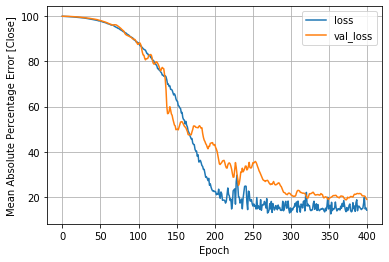

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error [Close]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

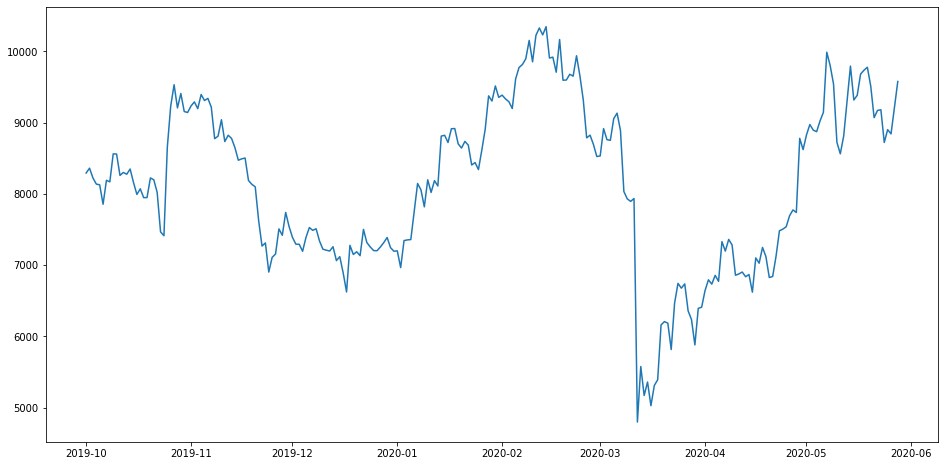

In [18]:

plt.figure(figsize=(16,8))
plt.plot(main_df["Close"],label='Close Price history')


No handles with labels found to put in legend.


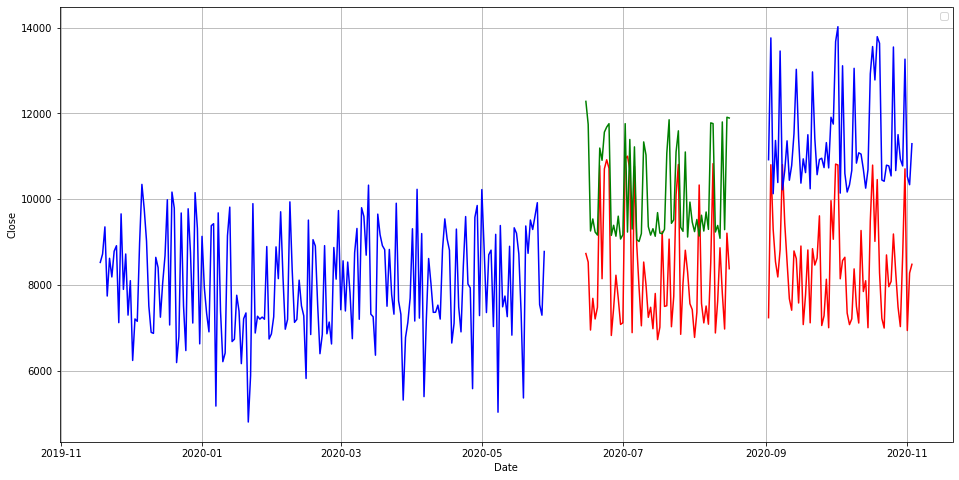

In [22]:
predict_y = model.predict(test_x)
predict_validation_y = model.predict(validation_x)

def plot_prediction():
  
  plt.figure(figsize=(16,8))
  d2predict = [w +   np.timedelta64(1, 'D')  for w in d2]
  d3predict = [w  + np.timedelta64(1, 'D')  for w in d3]
  
  
  plt.plot(d1,train_y , color = 'blue')
  plt.plot(d2,predict_validation_y , color = 'red')
  plt.plot(d2,validation_y ,color = 'green')
  plt.plot(d3,predict_y , color = 'red')
  plt.plot(d3,test_y , color = 'blue')
  
  
  #plt.ylim([0, 10])
  plt.xlabel('Date')
  plt.ylabel('Close')
  plt.savefig('BTC-USD predict.jpg')
  plt.legend()
  plt.grid(True)

plot_prediction()

No handles with labels found to put in legend.


[numpy.datetime64('2020-09-02T00:00:00.000000000'), numpy.datetime64('2020-09-03T00:00:00.000000000'), numpy.datetime64('2020-09-04T00:00:00.000000000'), numpy.datetime64('2020-09-05T00:00:00.000000000'), numpy.datetime64('2020-09-06T00:00:00.000000000'), numpy.datetime64('2020-09-07T00:00:00.000000000'), numpy.datetime64('2020-09-08T00:00:00.000000000'), numpy.datetime64('2020-09-09T00:00:00.000000000'), numpy.datetime64('2020-09-10T00:00:00.000000000'), numpy.datetime64('2020-09-11T00:00:00.000000000'), numpy.datetime64('2020-09-12T00:00:00.000000000'), numpy.datetime64('2020-09-13T00:00:00.000000000'), numpy.datetime64('2020-09-14T00:00:00.000000000'), numpy.datetime64('2020-09-15T00:00:00.000000000'), numpy.datetime64('2020-09-16T00:00:00.000000000'), numpy.datetime64('2020-09-17T00:00:00.000000000'), numpy.datetime64('2020-09-18T00:00:00.000000000'), numpy.datetime64('2020-09-19T00:00:00.000000000'), numpy.datetime64('2020-09-20T00:00:00.000000000'), numpy.datetime64('2020-09-21T0

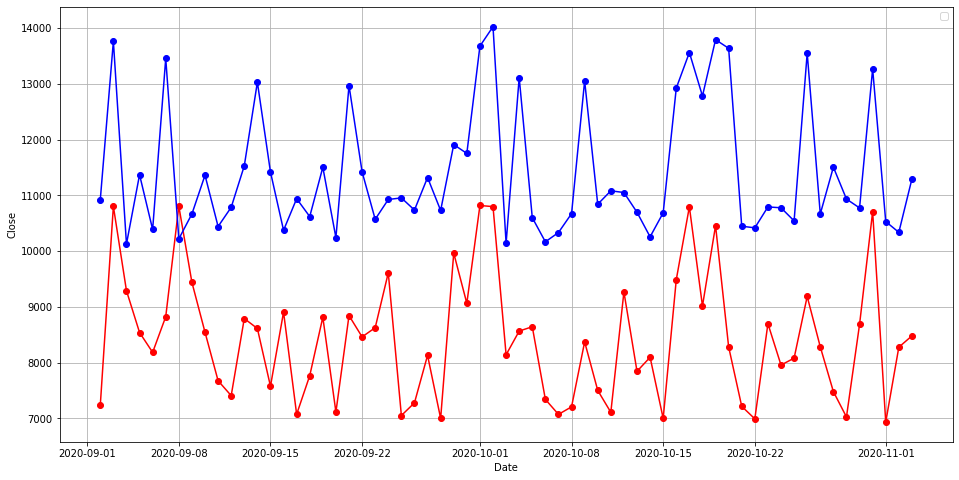

In [23]:
plt.figure(figsize=(16,8))


plt.plot(d3,predict_y ,'-ok', color = 'red')
plt.plot(d3,test_y ,'-ok', color = 'blue')


#plt.ylim([0, 10])
plt.xlabel('Date')
plt.ylabel('Close')
plt.savefig('BTC-USD predict.jpg')
plt.legend()
plt.grid(True)
print(d3)
